## Motion correction online

This notebook uses the code for motion correction online based on the motion corretion code from Online CNMF (OnAcid) from Caiman and from the original motion correction code from NoRMCorr.

If first opens the required packages for running the code, then sets the files to perform motion correction on and sets the required parameters for performing motion correction.

In [3]:
import logging
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.INFO)

import numpy as np

import caiman as cm
from caiman.source_extraction import cnmf
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_4000\3434187966.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_4000\3434187966.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


# Set data

Data can be set in a loop but should be set as a list and not as a string. 
Otherwise the code will turn them into a list.

Using '/' instead of '\\' allows to pass this code among operative systems

In [4]:
fnames = ["Z:/MP7/2023_01_06/2-photon/Rec4/mp7-1014-509-95_5min_15Hz_001.nd2"]

if isinstance(fnames,str):
    fnames = [fnames]

# Set parameters

This is where the parameters are set for motion correction. These are set as CNMF parameters because the online_motion_correction code is inside the online CNMF pipeline code. This may change in future updates.

The parameters are explained below 

In [5]:
gSig_filt = None                 #Gaussian filter size. It should normally be half the neuron size. Set it to none for 2-photon
pw_rigid = True                     #True if piece-wise motion correction should be used
strides = (96, 96)                  #Patch sizes in pixels.
overlaps = (24, 24)                 #Overlap between patches in pixels. This value normally does not have to be very high.
max_shifts_online = 40              #Maximum rigid shifts
max_deviation_rigid = (10,10)       #Maximum deviation in pixels between rigid shifts and shifts of individual patches
border_nan = 'copy'                 #flag for allowing NaN in the boundaries. True allows NaN, whereas 'copy' copies the 
                                            #value of the nearest data point.
shifts_opencv = True                #flag for applying shifts using cubic interpolation (otherwise FFT)
init_batch = 500                    #initial batch 
ds_factor = 2                       #Spatial binning factor. Have in account that if spatial binning is used, all values above are unaltered.
normalize = True                    #Whether to normalize each frame prior to online processing. Set it to False for 2 photon

params_dict = {'fnames': fnames,
               'gSig_filt': gSig_filt,
               'pw_rigid': pw_rigid,
               'strides': strides,
               'overlaps': overlaps,
               'max_shifts_online': max_shifts_online,
               'max_deviation_rigid': max_deviation_rigid,
               'border_nan': border_nan,
               'shifts_opencv': shifts_opencv,
               'init_batch': init_batch,
               'ds_factor': ds_factor}
opts = cnmf.params.CNMFParams(params_dict=params_dict)

     9935712 [params.py:                 set():976] [4000] Changing key fnames in group data from None to ['Z:/MP7/2023_01_06/2-photon/Rec4/mp7-1014-509-95_5min_15Hz_001.nd2']
     9935712 [params.py:                 set():976] [4000] Changing key max_shifts_online in group online from 10 to 40
     9935714 [params.py:                 set():976] [4000] Changing key init_batch in group online from 200 to 500
     9935715 [params.py:                 set():976] [4000] Changing key ds_factor in group online from 1 to 2
     9935715 [params.py:                 set():976] [4000] Changing key pw_rigid in group motion from False to True
     9935716 [params.py:                 set():976] [4000] Changing key overlaps in group motion from (32, 32) to (24, 24)
     9935716 [params.py:                 set():976] [4000] Changing key max_deviation_rigid in group motion from 3 to (10, 10)


# Extra variables

You can also set the precision with which you want the motion corrected images to be stored, which can save some storage space. We don't advise to store with less precision than the original recording.

You can also open a template as a numpy array if you want to match these images against a previous template. Useful for when you have two channels or sucessive recordings of the same FOV with similar signal and background.

In [8]:
#These are extra variables
nbits = np.float16                          #Number of bits in which to save final images as tiff files.
init_template = None                #If an initial template can be provided, this should be where to set this variable into 
                                           #the template 2D numpy array.

# Run online motion correction

In [9]:
cnm = cnmf.online_cnmf.OnACID(params=opts)
cnm.motion_correction_online(template = init_template, save_movie=True,nbits=nbits)

    10089607 [online_cnmf.py:motion_correction_online():944] [4000] Analyzing Z:/MP7/2023_01_06/2-photon/Rec4/mp7-1014-509-95_5min_15Hz_001.nd2
    10118749 [online_cnmf.py:motion_correction_online():977] [4000] Initial template initialized in 29 seconds
    10119124 [online_cnmf.py:motion_correction_online():1007] [4000] Start processing all frames
    10132536 [online_cnmf.py:motion_correction_online():1080] [4000] Processed and saved 500 frames in 13 seconds
    10146153 [online_cnmf.py:motion_correction_online():1080] [4000] Processed and saved 1000 frames in 27 seconds
    10159714 [online_cnmf.py:motion_correction_online():1080] [4000] Processed and saved 1500 frames in 40 seconds
    10173407 [online_cnmf.py:motion_correction_online():1080] [4000] Processed and saved 2000 frames in 54 seconds
    10187189 [online_cnmf.py:motion_correction_online():1080] [4000] Processed and saved 2500 frames in 68 seconds
    10200360 [online_cnmf.py:motion_correction_online():1080] [4000] Proce

# Plot x and y shifts

[Text(0.5, 1.0, 'Y shifts'),
 Text(0.5, 0, 'Frames'),
 Text(0, 0.5, 'Pixel shift')]

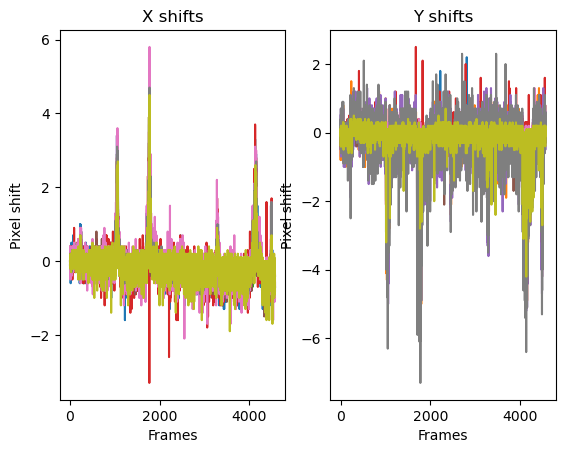

In [14]:
T = len(cnm.estimates.shifts) #Calculated shifts
    
#Get x and y shifts
shifts = cnm.estimates.shifts[-T:]
if (pw_rigid is True):
    y_shifts = [[sx[1] for sx in sh] for sh in shifts]
    x_shifts = [[sx[0] for sx in sh] for sh in shifts]

else:
    y_shifts = [sh[1] for sh in shifts]
    x_shifts = [sh[0] for sh in shifts]
    
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x_shifts)
ax1.set(title = 'X shifts', xlabel = 'Frames', ylabel = 'Pixel shift')
ax2.plot(y_shifts)
ax2.set(title = 'Y shifts', xlabel = 'Frames', ylabel = 'Pixel shift')